In [1]:
#export
import math as _math, k1lib as _k1lib
import matplotlib.pyplot as _plt, numpy as _np
from itertools import accumulate as _accumulate
import typing as _typing
from typing import List as _List, Callable as _Callable,\
Union as _Union

In [2]:
#export
ScheduleF = _typing.Callable[[float], float]

In [3]:
#export
def combine(lambdas:_List[ScheduleF], ratios:_List[float]=None) -> ScheduleF:
    """Combine multiple different schedules.

:param ratios: weighting diferent functions. Does not have to
    add up to 1.
:param lambdas: functions with 1 float input in [0, 1]"""
    if ratios == None: ratios = [1] * len(lambdas)
    ratios = _np.array(ratios)
    ratios = ratios / ratios.sum()
    checkpoints = [0] + list(_accumulate(ratios))
    def f(x):
        for idx, checkpoint in enumerate(checkpoints):
            if checkpoint > x: break
        a = checkpoints[idx - 1]
        return lambdas[idx - 1]((x - a)/(checkpoints[idx] - a))
    return f
def decorate(f:_Callable[[float, float, float], float]) -> _Callable[[float], float]:
    """Decorator, transforms f(low, high, x) to (low, high) -> f(x)."""
    def _f(low, high): return lambda x: f(low, high, x)
    _f.__doc__ = f.__doc__; return _f

In [4]:
#export
@decorate
def linear(low, high, x): return low + x * (high - low)
@decorate
def cosine(low, high, x): return low + (high - low) * (1 + _math.cos(_math.pi * (1-x))) / 2
def oneCycle(low, high): return combine([cosine(0.8 * low + 0.2 * high, high), cosine(high, low)], [0.3, 0.7])
_en4 = _math.e**-3
@decorate
def decay(low, high, x): return (_math.exp(-x*4+1) - _en4) / (_math.e - _en4) * (low - high) + high

In [5]:
#export
class Schedule:
    def __init__(self, param:str, scheduleF:ScheduleF):
        self.param = param; self.scheduleF = scheduleF; self.progress = None
    def __call__(self, x:float): return self.scheduleF(x)
    def startBatch(self, paramGroup:dict, progress:float):
        paramGroup[self.param] = self.scheduleF(progress)
        self.progress = progress
    @property
    def value(self): return self.scheduleF(self.progress)
    def __repr__(self):
        _plt.figure(dpi=100); c = dict(color="tab:green")
        x = _np.linspace(0, 1, 1000); y = [self.scheduleF(x) for x in x]; _plt.plot(x, y)
        y = self(0); _plt.plot(0, y, "o", **c); _plt.annotate("(0, {:.1e})".format(y), (0, y))
        y = self(1); _plt.plot(1, y, "o", **c); _plt.annotate("(1, {:.1e})".format(y), (1, y))
        if (x := self.progress) is not None:
            blur = not (x in _k1lib.Range(0.1, 0.9))
            y = self(x); _plt.plot(x, y, "o", **c, alpha=(0.5 if blur else 1))
            if not blur: _plt.annotate("({:.1e}, {:.1e})".format(x, y), (x, y))
        _plt.show()
        return f"""'{self.param}' schedule. Can...
- s.progress: to get last recorded progress
- s.value: to get last recorded hyper parameter's value
- s(0.3): to get value of schedule at 30% progress"""
    @staticmethod
    def linear(param:str, low:float, high:float) -> _Callable[[float], float]:
        """Sharply goes from low to high"""
        return Schedule(param, linear(low, high))
    @staticmethod
    def cosine(param:str, low:float, high:float) -> _Callable[[float], float]:
        """Smoothly goes from low to high"""
        return Schedule(param, cosine(low, high))
    @staticmethod
    def oneCycle(param:str, low:float, high:float, upPortion:float=0.3) -> _Callable[[float], float]:
        """Goes from middle-low (0.8*low + 0.2*high) to high to low

:param upPortion: the percent of portion that goes up"""
        return Schedule(param, combine([cosine(0.8 * low + 0.2 * high, high), cosine(high, low)], [upPortion, 1-upPortion]))
    @staticmethod
    def decay(param:str, low:float, high:float) -> _Callable[[float], float]:
        """Rises/drops quickly, then rate of change gets smaller and smaller"""
        return Schedule(param, decay(low, high))

In [6]:
#export
@_k1lib.patch(_k1lib.Callback.cls)
class ParamScheduler(_k1lib.Callback):
    """Schedules a param in parts of the network.
    
:param css: the selected parts of the network to schedule
:param schedules: (obvious)"""
    def __init__(self, css:str, schedules:_Union[_List[Schedule], Schedule]):
        super().__init__(); self.css = css; schedules = schedules or []
        schedules = [schedules] if isinstance(schedules, Schedule) else schedules
        self.schedules = {s.param:s for s in schedules}
        self.groupId = None; self.dependsOn = set("ProgressBar")
        self.initialized = False; self.prop = None
    def endRun(self):
        ":meta private:"
        self.initialized = False
    def __getstate__(self):
        answer = dict(self.__dict__)
        if "selector" in answer: del answer["selector"]
        return answer
    def startBatch(self):
        ":meta private:"
        if self.l.model.training:
            paramGroup = self.l.opt.param_groups[self.groupId]
            progress = self.l.ProgressBar.progress
            for schedule in self.schedules.values(): schedule.startBatch(paramGroup, progress)
    def __repr__(self):
        print(f"{self._reprHead}, css: \"{self.css}\", selector prop: \"{self.prop}\", schedules:")
        for schedule in self.schedules.values(): schedule.__repr__()
        return f"""Can...
- ps.schedules["lr"]: to get the schedule for a specific param
- ps.selector: to view the selected parameters
{self._reprCan}"""

In [7]:
#export
@_k1lib.patch(ParamScheduler, name="startRun")
def _startRun(self):
    "meta:private"
    if not self.initialized:
        # get all other ParamSchedulers
        cbs = [cb for cb in self.l.cbs if isinstance(cb, ParamScheduler) and not cb.suspended]
        # delete all old _ps_{i} selectors, and add new ones
        css = [line for line in self.l.css.split("\n") if "_ps_" not in line]
        for i, cb in enumerate(cbs):
            cb.prop = f"_ps_{i}"; css += _k1lib.selector.filter(cb.css, cb.prop)
            cb.initialized = True # make sure only 1 startRun is ran across all ParamSchedulers
        self.l.css = "\n".join(css)
        # sort cbs based on depth, so that deeper ones gets accounted for first
        for cb in cbs: cb._depth = next(self.l.selector.modules(cb.prop)).depth
        cbs = sorted(cbs, key=lambda cb: -cb._depth)
        # clear and add param groups
        self.l.opt.param_groups = []
        allParams = set(self.l.selector.parameters())
        for cb in cbs:
            params = set()
            for m in self.l.selector.modules(cb.prop):
                for p in m.parameters():
                    if p in allParams:
                        params.add(p); allParams.remove(p)
            if len(params) > 0:
                cb.groupId = len(self.l.opt.param_groups)
                self.l.opt.add_param_group({"prop": cb.prop, "css": cb.css, "params": list(params), **self.l.opt.defaults})
        self.l.opt.add_param_group({"prop": "rest", "css": "*", "params": list(allParams), **self.l.opt.defaults})
        for cb in cbs:
            params = set(self.l.opt.param_groups[cb.groupId]["params"])
            cb.selector = self.l.selector.copy()
            def applyF(mS):
                mS.displayF = lambda s: "*" if any([p in params for p in s.directParams.values()]) else ""
            cb.selector.apply(applyF)

In [8]:
#export
@_k1lib.patch(_k1lib.Callbacks, docs=ParamScheduler, name="withParamScheduler")
def _withParamScheduler(self, css:str, schedules:list, name:str=None):
    return self.append(ParamScheduler(css, schedules), name=name)

In [11]:
!../export.py schedule

Current dir: /home/kelvin/repos/labs/k1lib, ../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 0.1.7
Uninstalling k1lib-0.1.7:
  Successfully uninstalled k1lib-0.1.7
running install
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top_level.txt
writing manifest file 'k1lib.egg-info/SOURCES.txt'
reading manifest file 'k1lib.egg-info/SOURCES.txt'
writing manifest file 'k1lib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/k1lib
copying k1lib/_learner.py -> build/lib/k1lib
copying k1lib/data.py -> build/lib/k1lib
copying k1lib/selector.py -> build/lib/k1lib
copying k1lib/imports.py -> build/lib/k1lib
copying k1lib/_basi

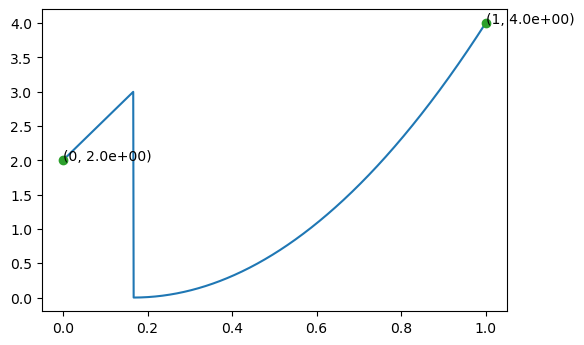

'a' schedule. Can...
- s.progress: to get last recorded progress
- s.value: to get last recorded hyper parameter's value
- s(0.3): to get value of schedule at 30% progress

In [10]:
Schedule("a", combine([lambda x: x+2, lambda x: (x*2)**2], [2, 10])) # vanilla

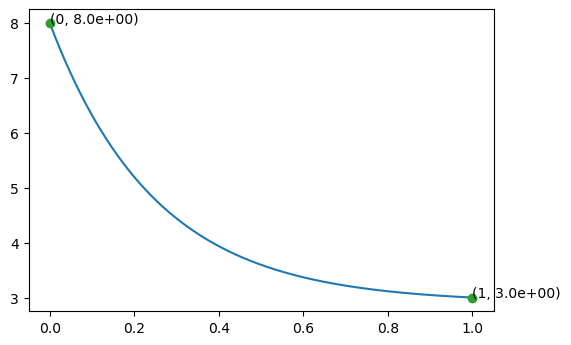

'lr' schedule. Can...
- s.progress: to get last recorded progress
- s.value: to get last recorded hyper parameter's value
- s(0.3): to get value of schedule at 30% progress

In [11]:
Schedule("lr", decay(8, 3))

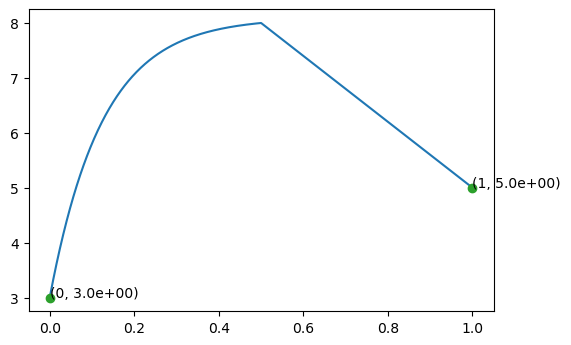

'lr' schedule. Can...
- s.progress: to get last recorded progress
- s.value: to get last recorded hyper parameter's value
- s(0.3): to get value of schedule at 30% progress

In [12]:
Schedule("lr", combine([decay(3, 8), linear(8, 5)]))

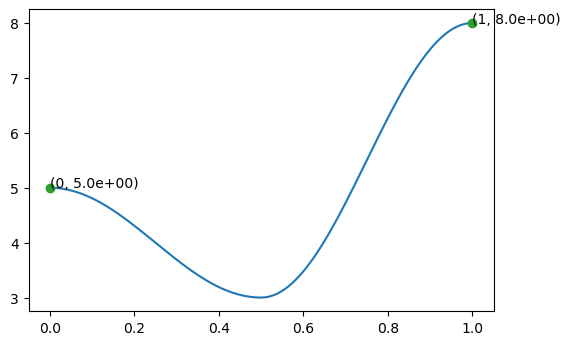

'lr' schedule. Can...
- s.progress: to get last recorded progress
- s.value: to get last recorded hyper parameter's value
- s(0.3): to get value of schedule at 30% progress

In [13]:
Schedule("lr", combine([cosine(5, 3), cosine(3, 8)]))

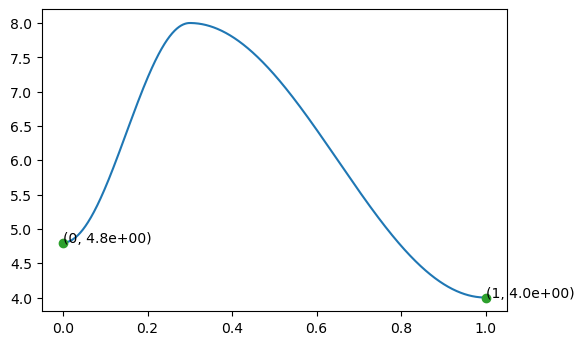

'lr' schedule. Can...
- s.progress: to get last recorded progress
- s.value: to get last recorded hyper parameter's value
- s(0.3): to get value of schedule at 30% progress

In [14]:
Schedule("lr", oneCycle(4, 8))